# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Вот так напишут всё, что сделать надо, и не напишешь нормальный план работы.

Всего у нас будет 3 этапа:

1. Подготовка данных. Здесь мы исследует каждую переменную и доведём её до удобоваримого для модели состояния
2. Напишем функцию, которая сделает сразу несколько пунктов: сделает модели ohe, отмасштабирует, разобьёт выборку на нужные df, подберёт оптимальную модель с точки зрения метрики f1 и проверит её на тестовой выборке и на адекватность
3. Выводы

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-deep')

df = pd.read_csv('/datasets/Churn.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Видны пропуски, тип `float` и переменные с сомнительной ценностью для будущей модели. Будем разбираться.

Старая функция `column_info` показывает информацию по переменной.

In [2]:
def column_info(data, column, quantitative=False, mean=True, median=True, hist=True, bins=30):    
    lost = data[column].isna().sum() #смотрим количество пропусков
    total = data.shape[0] #длина всех значений переменной
    print('Тип данных столбца {}: {}:'.format(column, data[column].dtype))
    print('В столбце {} пропущено {} из {} строк, что составляет {:.2%}'
          .format(column, lost, total, lost / total)) #считаем процент пропусков
    if quantitative:        
        print('Минимальное значение: {}'.format(data[column].min()))
        print('Максимальное значение: {}'.format(data[column].max()))
        if mean:
            print('Среднее значение: {:.2f}'.format(data[column].mean()))
        if median:
            print('Медианное значение: {}'.format(data[column].median()))
        if hist:
            fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
            sns.distplot(data[column], bins=bins, ax=axs[0])
            sns.boxplot(data[column], ax=axs[1])            
            plt.show()            
    else:
        print()
        print('Количество значений в каждой из категорий:')
        print(data[column].value_counts())        
    print()

In [3]:
df.columns = [i.lower() for i in df.columns]

In [4]:
df.duplicated().sum()

0

Чисто на всякий случай.

Зададимся вопросом: Есть ли у нас одни и те же люди, кто пользовался услугами банка несколько раз?

In [5]:
len(df['customerid'].unique())

10000

Таких не обнаружено, а это значит, что переменная `customerid` не нужна. Едва ли вероятность ухода клиента зависит от первой буквы в фамилии.

Таким образом переменнвые `RowNumber`, `customerid`, `surname` можно убрать за ненадобностью. Их роль на себя с лёгкостью берёт индекс.

Тип данных столбца creditscore: int64:
В столбце creditscore пропущено 0 из 10000 строк, что составляет 0.00%
Минимальное значение: 350
Максимальное значение: 850
Среднее значение: 650.53
Медианное значение: 652.0


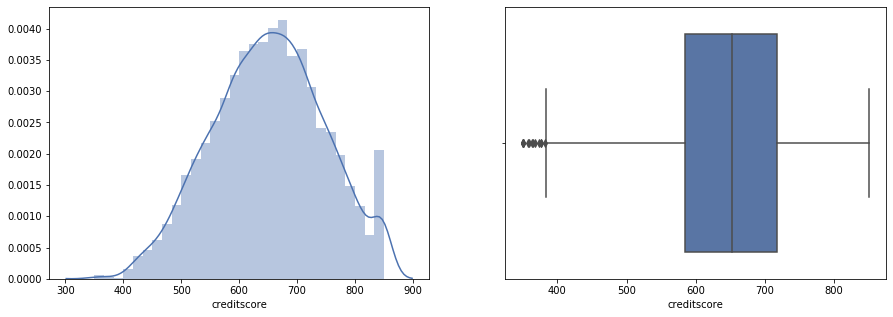

In [6]:
column_info(df, 'creditscore', quantitative=True)

Распределение похоже на нормальное, все значения адекватные, так что выбросы не выбросы.

In [7]:
column_info(df, 'geography')

Тип данных столбца geography: object:
В столбце geography пропущено 0 из 10000 строк, что составляет 0.00%

Количество значений в каждой из категорий:
France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64



Всего 3 страны, для ohe самое то.

In [8]:
column_info(df, 'gender') 

Тип данных столбца gender: object:
В столбце gender пропущено 0 из 10000 строк, что составляет 0.00%

Количество значений в каждой из категорий:
Male      5457
Female    4543
Name: gender, dtype: int64



Всего 2 пола, малова-то по современным стандартам.

Тип данных столбца age: int64:
В столбце age пропущено 0 из 10000 строк, что составляет 0.00%
Минимальное значение: 18
Максимальное значение: 92
Среднее значение: 38.92
Медианное значение: 37.0


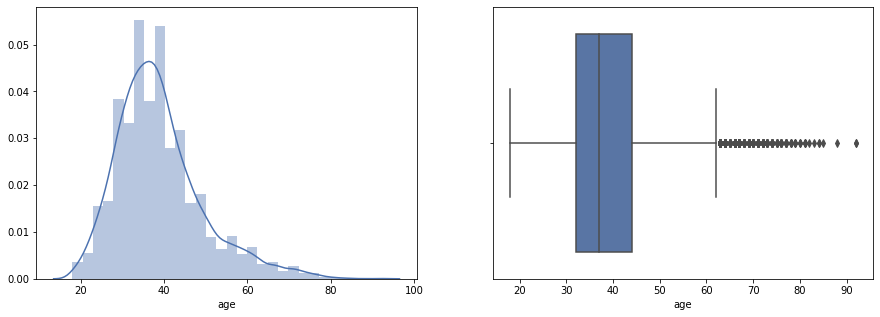

In [9]:
column_info(df, 'age', quantitative=True, bins=30)

Распределение похоже на нормальное, все значения адекватные, так что выбросы не выбросы.

Тип данных столбца tenure: float64:
В столбце tenure пропущено 909 из 10000 строк, что составляет 9.09%
Минимальное значение: 0.0
Максимальное значение: 10.0
Среднее значение: 5.00
Медианное значение: 5.0


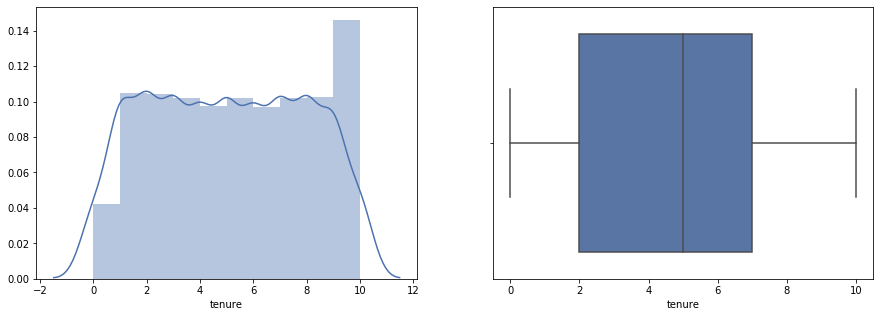

In [10]:
column_info(df, 'tenure', quantitative=True, bins=10)

Значений слишком мало, чтобы говорить о характере распределения.

Это единственная переменная с пропусками, заполним её медианой, чтобы потом можно было скормить её модели и перевести в тип `int`. 

Конечно, можно разбить выборку на категории по уровню дохода и брать медианы по категориям, но для данной задачи это может иметь минимальный эффект, поэтому пока заполним медианой по всей выборке, а если не будем получать требуемый критерий для выполнения задания, то вернёмся и заполним по категориям.

In [11]:
df['tenure'].fillna(df['tenure'].median(), inplace=True)

Тип данных столбца balance: float64:
В столбце balance пропущено 0 из 10000 строк, что составляет 0.00%
Минимальное значение: 0.0
Максимальное значение: 250898.09
Среднее значение: 76485.89
Медианное значение: 97198.54000000001


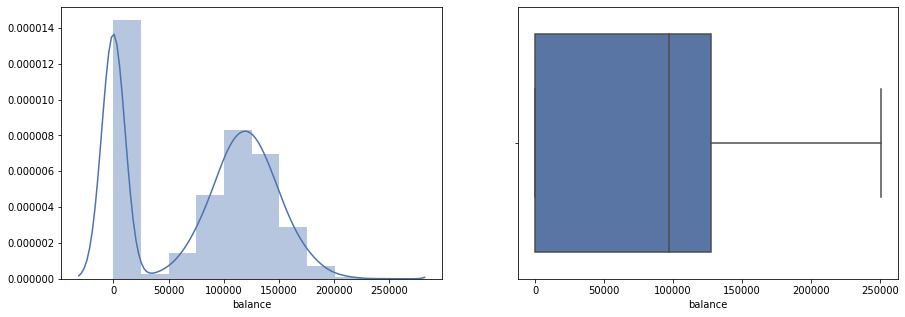

In [12]:
column_info(df, 'balance', quantitative=True, bins=10)

Распределение было бы нормальным, если бы не большое количество 0-х значений.

Тип данных столбца numofproducts: int64:
В столбце numofproducts пропущено 0 из 10000 строк, что составляет 0.00%
Минимальное значение: 1
Максимальное значение: 4
Среднее значение: 1.53
Медианное значение: 1.0


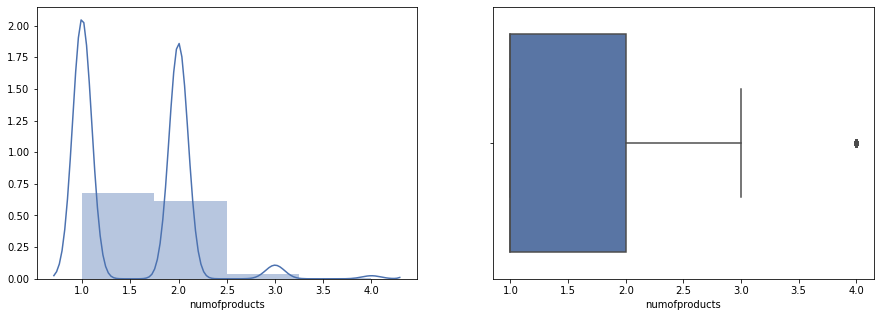

In [13]:
column_info(df, 'numofproducts', quantitative=True, bins=4)

Тут тоже всё в порядке, по такому количеству значений нельзя сделать вывод о распределении.

In [14]:
column_info(df, 'hascrcard')

Тип данных столбца hascrcard: int64:
В столбце hascrcard пропущено 0 из 10000 строк, что составляет 0.00%

Количество значений в каждой из категорий:
1    7055
0    2945
Name: hascrcard, dtype: int64



In [15]:
column_info(df, 'isactivemember')

Тип данных столбца isactivemember: int64:
В столбце isactivemember пропущено 0 из 10000 строк, что составляет 0.00%

Количество значений в каждой из категорий:
1    5151
0    4849
Name: isactivemember, dtype: int64



Тип данных столбца estimatedsalary: float64:
В столбце estimatedsalary пропущено 0 из 10000 строк, что составляет 0.00%
Минимальное значение: 11.58
Максимальное значение: 199992.48
Среднее значение: 100090.24
Медианное значение: 100193.915


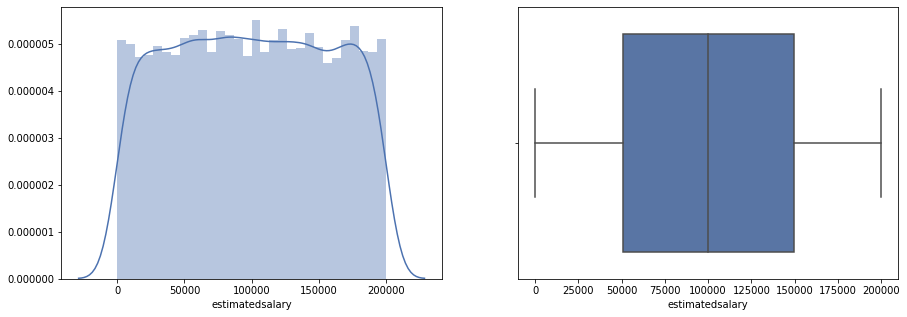

In [16]:
column_info(df, 'estimatedsalary', quantitative=True)

Равномерное распределение в доходах. Кажется, действие происходит не в России, и не в США и не на планете Земля.

In [17]:
column_info(df, 'exited')

Тип данных столбца exited: int64:
В столбце exited пропущено 0 из 10000 строк, что составляет 0.00%

Количество значений в каждой из категорий:
0    7963
1    2037
Name: exited, dtype: int64



А вот тут уже видно, что сильного дисбаланса классов нет: подумаешь 1:4. На консультации говорили, что волноваться стоит начинать при соотношении 1:10. Но в дальнейшем мы увидим, что всё-таки перебалансировка нам поможет улучшить метрики.

А есть ли у нас переменные, корреляция между которыми составляет больше 0.5?

In [18]:
df_corr = df.corr()
df_corr[abs(df_corr) > 0.5].count()

rownumber          1
customerid         1
creditscore        1
age                1
tenure             1
balance            1
numofproducts      1
hascrcard          1
isactivemember     1
estimatedsalary    1
exited             1
dtype: int64

Всю матрицу рисовать не будем, всё равно мало что видно. А вот при такой подаче видно, что сильной корреляции (как тут называют коллинеарности) между переменными нет, так что все оставляем.

Итак, выкидываем бесполезные переменные, а тип `float` переводим в `int`. Модель может не ускорим, а памяти немного сэкономии, хотя сдаётся мне, это больше эстетика.

In [19]:
df.drop(['rownumber', 'customerid', 'surname'], axis=1, inplace=True)
float_columns = ['tenure', 'balance', 'estimatedsalary']
df[float_columns] = df[float_columns].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
creditscore        10000 non-null int64
geography          10000 non-null object
gender             10000 non-null object
age                10000 non-null int64
tenure             10000 non-null int64
balance            10000 non-null int64
numofproducts      10000 non-null int64
hascrcard          10000 non-null int64
isactivemember     10000 non-null int64
estimatedsalary    10000 non-null int64
exited             10000 non-null int64
dtypes: int64(9), object(2)
memory usage: 859.5+ KB


# 2. Исследование задачи

Сделаем функцию, которая будет выполнять почти всю работу, предполагаемую проектом. Функция возвращает лучшую модель.

- data - исследуемый DataFrame
- tar_var - целевой признак
- numeric - список тех переменных, которые мы признаём количественными
- scale - нужно ли делать масштабирование
- balanced - нужно ли в логистической регресии применять к классам пропорциональный вес
- upsample - нужно ли перебалансировать классы добавлением меньшего класса
- value - значение целевого класса

In [20]:
def best_learn_categorial_model(data, tar_var, numeric, scale=False, balanced=False, upsample=False,
                                value=1):
    
    print()
    print('***Поехали!***')
    print() 
    
    #Масшбабируем количественные переменные
    
    if scale:    
        scaler = StandardScaler()
        scaler.fit(data[numeric])
        data[numeric] = scaler.transform(data[numeric])    
    print('***Масштабирование количественных переменных прошло успешно***')
    print()
    
    #Интерпретируем категориальные переменные с помощью чисел ohe-методом
    
    df_ohe = pd.get_dummies(data, drop_first=True)
    print('***Перевод категориальных переменных в количественные ohe-методом прошёл успешно***')
    print()
    
    #Делим выбоки на переменные признаки и целевые признаки
    
    features = df_ohe.drop(tar_var, axis=1)
    target = df_ohe[tar_var]

    #Делим данные на тренировочную, валидационную и тестовую выборки в отношении 3:1:1
    
    features_train_valid, features_test, target_train_valid, target_test = (
        train_test_split(features, target, test_size=0.2, random_state=21))
    features_train, features_valid, target_train, target_valid = (
        train_test_split(features_train_valid, target_train_valid, test_size=0.25, random_state=21))
    print('Объём тренировочной выборки:', len(features_train))
    print('Объём валидационной выборки:', len(features_valid))
    print('Объём тестовой выборки:', len(features_test))
    print()
    print('***Разделение выборки на тренировочную, валидационную и тестовую прошло успешно***')
    print()    
    
    #Апсемпл
    
    def upsample(features, target):
        features_withoutvalue = features[target != value]
        features_withvalue = features[target == value]
        target_withoutvalue = target[target != value]
        target_withvalue = target[target == value]
        
        print('Баланс классов в тренировочной выборке до апсемплинга:', len(features_withvalue),
              ':', len(features_withoutvalue), '= {:.2f}'.format(len(features_withvalue) / 
                                                                 len(features_withoutvalue))) 
        print()
        
        repeat = round(len(features_withoutvalue) / len(features_withvalue))
        
        features_upsampled = pd.concat([features_withoutvalue] + [features_withvalue] * repeat)
        target_upsampled = pd.concat([target_withoutvalue] + [target_withvalue] * repeat)
        
        features_upsampled_withvalue = features_upsampled[target == value]
        features_upsampled_withoutvalue = features_upsampled[target != value]
        
        print('Баланс классов в тренировочной выборке после апсемплинга:', 
              len(features_upsampled_withvalue), ':', len(features_upsampled_withoutvalue),
              '= {:.2f}'.format(len(features_upsampled_withvalue) / 
                                len(features_upsampled_withoutvalue))) 
        print()

        features_upsampled, target_upsampled = shuffle(
            features_upsampled, target_upsampled, random_state=21)

        return features_upsampled, target_upsampled    
    
    if balanced:        
        features_train_valid, target_train_valid = upsample(features_train_valid, target_train_valid)
        print('***Апсэмплинг прошёл успешно***')
        print()
    
    #Logistic
    
    if balanced:
        model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=21)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        f1_logistic = f1_score(target_valid, predictions_valid)        
    else:
        model = LogisticRegression(solver='liblinear', random_state=21)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        f1_logistic = f1_score(target_valid, predictions_valid)
        
    print('***Результаты логистической модели***')   
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]   
    auc_roc_logistic = roc_auc_score(target_valid, probabilities_one_valid) 
    
    fig = plt.subplots(figsize=(2, 4))
    sns.barplot(x=['f1', 'roc_auc'], y=[f1_logistic, auc_roc_logistic])
    plt.show()
    
    print('f1: {:.2f}'.format(f1_logistic))
    print('roc_auc: {:.2f}'.format(auc_roc_logistic))
    print()
    
    #Forest
    
    best_f1 = 0
    best_depth = 1
    best_estim = 1    
    #Знаю, есть GridSearchCV, но говорят, он будет потом, решил пока обойтись циклами    
    for i in range(1, 20):
        for j in range(1, 45):
            model = RandomForestClassifier(max_depth=i, n_estimators=j, random_state=21)
            model.fit(features_train, target_train)
            predictions_valid = model.predict(features_valid)
            f1_forest = f1_score(target_valid, predictions_valid)
            if f1_forest > best_f1:
                best_f1 = f1_forest
                best_depth = i
                best_estim = j
      
    model = RandomForestClassifier(max_depth=best_depth, n_estimators=best_estim, random_state=21)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)      
    f1_forest = f1_score(target_valid, predictions_valid)
    
    print('***Результаты леса***')   
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]   
    auc_roc_forest = roc_auc_score(target_valid, probabilities_one_valid) 
    
    fig = plt.subplots(figsize=(2, 4))
    sns.barplot(x=['f1', 'roc_auc'], y=[f1_forest, auc_roc_forest])
    plt.show()
    
    print('f1: {:.2f}'.format(f1_forest))
    print('roc_auc: {:.2f}'.format(auc_roc_forest))
    print()
    print('С гиперпараметрами max_depth: {:.2f} и n_estimators: {:.2f}'
          .format(best_depth, best_estim))  
    print() 
    
    #Среди моделей выбираем ту, которая даёт лучший рузультат. Обучаем эту модель сразу на 
    #тренировочной и валидационной выборках.
    
    if f1_logistic < f1_forest:
        print('***Лес победил. Модель учит лес***')
        print()
        model = RandomForestClassifier(max_depth=best_depth, n_estimators=best_estim, random_state=21)
        model.fit(features_train_valid, target_train_valid)
    else:   
        print('***Логистика победила. Модель учит логистика***')
        print()
        if balanced:
            model = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=21)
            model.fit(features_train_valid, target_train_valid)            
        else:
            model = LogisticRegression(solver='liblinear', random_state=21)
            model.fit(features_train_valid, target_train_valid)         
    
    #Проверяем модель на тестовой выборке
    
    probabilities_test = model.predict_proba(features_test)
    probabilities_one_test = probabilities_test[:, 1]   
    auc_roc = roc_auc_score(target_test, probabilities_one_test)
    predictions_test = model.predict(features_test)
    f1 = f1_score(target_test, predictions_test)
    
    fig = plt.subplots(figsize=(2, 4))
    sns.barplot(x=['f1', 'roc_auc'], y=[f1, auc_roc])
    plt.show()
    
    print('***Результаты на тестовой выборке***')
    print('f1: {:.2f}'.format(f1))
    print('roc_auc: {:.2f}'.format(auc_roc))
    print()
    
    #Насколько конфузится модель?
    
    print('***Матрица конфузии финальной модели:***')
    print()
    print(confusion_matrix(target_test, predictions_test))
    print()
    
    #Проверяем модель на адекватность. Заполняем 0 и 1 в соотвествии с вероятностью их появления
    
    probabilities = np.bincount(target_train_valid)
    zero_prob = probabilities[0] / (probabilities[0] + probabilities[1])
    one_prob = probabilities[1] / (probabilities[0] + probabilities[1])
    predictions_test = [rd.choices([0, 1], weights=[zero_prob, one_prob], 
                                   k=1)[0] for i in range(len(target_test))]
    
    f1_nonadeq = f1_score(target_test, predictions_test)
    probabilities_one_valid = [one_prob for i in range(len(target_train_valid))]
    auc_roc_nonadeq = roc_auc_score(target_train_valid, probabilities_one_valid)
    
    print('***Неадекватная модель***')    
    print()
    print('f1: {:.2f}'.format(f1_nonadeq))
    print('roc_auc: {:.2f}'.format(auc_roc_nonadeq))
    print()
    print('***Сравнение неадекватной моделью с лучшей моделью***')
    pd.DataFrame(data={'неадекватная': [f1_nonadeq, auc_roc_nonadeq], 'лучшая': [f1, auc_roc]}, 
                 index=['f1', 'roc_auc']).plot(kind='bar', figsize=(4,4))
    plt.legend(loc=2, frameon=False)    
    plt.show()
    print()
    
    return model


***Поехали!***

***Масштабирование количественных переменных прошло успешно***

***Перевод категориальных переменных в количественные ohe-методом прошёл успешно***

Объём тренировочной выборки: 6000
Объём валидационной выборки: 2000
Объём тестовой выборки: 2000

***Разделение выборки на тренировочную, валидационную и тестовую прошло успешно***

***Результаты логистической модели***


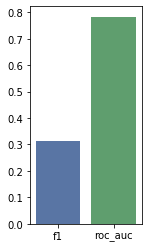

f1: 0.31
roc_auc: 0.78

***Результаты леса***


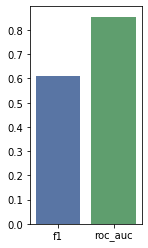

f1: 0.61
roc_auc: 0.85

С гиперпараметрами max_depth: 14.00 и n_estimators: 35.00

***Лес победил. Модель учит лес***



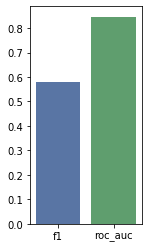

***Результаты на тестовой выборке***
f1: 0.58
roc_auc: 0.85

***Матрица конфузии финальной модели:***

[[1547   53]
 [ 216  184]]

***Неадекватная модель***

f1: 0.19
roc_auc: 0.50

***Сравнение неадекватной моделью с лучшей моделью***


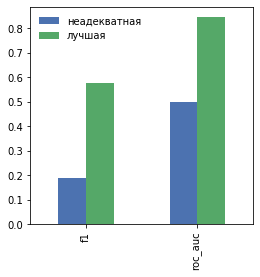

In [21]:
numeric = ['creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'estimatedsalary']

_ = best_learn_categorial_model(df, 'exited', numeric=numeric, scale=True)


***Поехали!***

***Масштабирование количественных переменных прошло успешно***

***Перевод категориальных переменных в количественные ohe-методом прошёл успешно***

Объём тренировочной выборки: 6000
Объём валидационной выборки: 2000
Объём тестовой выборки: 2000

***Разделение выборки на тренировочную, валидационную и тестовую прошло успешно***

Баланс классов в тренировочной выборке до апсемплинга: 1637 : 6363 = 0.26

Баланс классов в тренировочной выборке после апсемплинга: 6548 : 6363 = 1.03

***Апсэмплинг прошёл успешно***

***Результаты логистической модели***


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


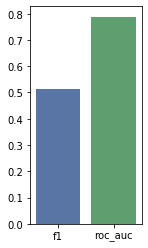

f1: 0.51
roc_auc: 0.79

***Результаты леса***


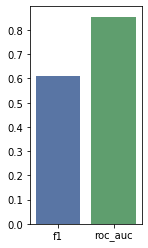

f1: 0.61
roc_auc: 0.85

С гиперпараметрами max_depth: 14.00 и n_estimators: 35.00

***Лес победил. Модель учит лес***



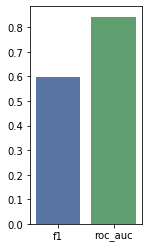

***Результаты на тестовой выборке***
f1: 0.60
roc_auc: 0.84

***Матрица конфузии финальной модели:***

[[1432  168]
 [ 158  242]]

***Неадекватная модель***

f1: 0.28
roc_auc: 0.50

***Сравнение неадекватной моделью с лучшей моделью***


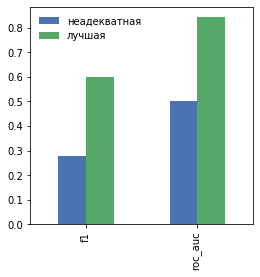

In [22]:
_ = best_learn_categorial_model(df, 'exited', numeric=numeric, balanced=True, scale=True)

**Вывод про перебалансировку** С одной стороны плохо, что таким подходом можно повысить количество целевых строк только в целое количество раз (по одному добавлять сложно, так как нужно учитывать такие строки уже попали в новую таблицу), а с другой стороны, что это за дисбаланс классов, когда целыми числами нельзя устранить баланс.

Почему, я думаю, что почти всегда нужно предпочесть апсемплинг даунсемплингу? Потому что когда мы удаляем, то теряем реальные данные, на которых модель может учиться, а вот когда добавляем уже имеющиеся данные, то по-сути информауия остаётся прежней, просто мы повышаем значимость того или иного класса.

# 3. Вывод

In [64]:
(pd.DataFrame(data={'unbalanced': [0.31, 0.78, 0.58, 0.85, 0.19, 0.5], 
                   'balanced': [0.51, 0.79, 0.6, 0.84, 0.28, 0.5], 
                   'model': ['logistic', 'logistic', 'forest', 'forest', 'random', 'random'], 
                   'metrics': ['f1', 'roc_auc', 'f1', 'roc_auc', 'f1', 'roc_auc'] })
                   .set_index(['model', 'metrics'])
)

unbalanced  balanced
model    metrics                      
logistic f1             0.31      0.51
         roc_auc        0.78      0.79
forest   f1             0.58      0.60
         roc_auc        0.85      0.84
random   f1             0.19      0.28
         roc_auc        0.50      0.50

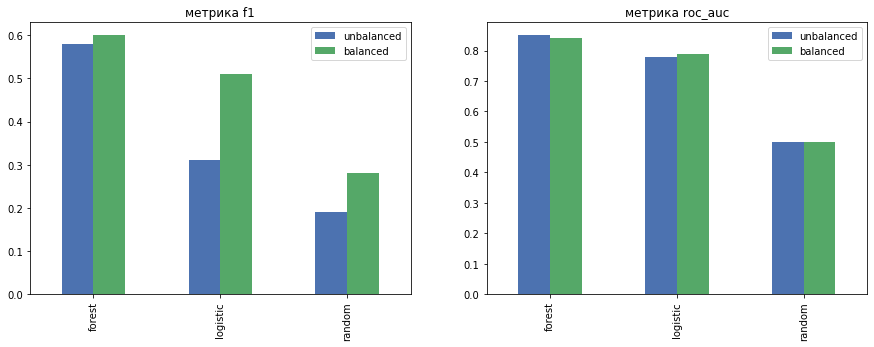

In [63]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
(pd.DataFrame(data={'unbalanced': [0.31, 0.58, 0.19], 
                    'balanced': [0.51, 0.6, 0.28]}, index = ['logistic', 'forest', 'random'])
                    .sort_values(by='balanced', ascending=False)
                    .plot(kind='bar', title='метрика f1', ax=axs[0])
)
(pd.DataFrame(data={'unbalanced': [0.78, 0.85, 0.5], 
                    'balanced': [0.79, 0.84, 0.5]}, index = ['logistic', 'forest', 'random'])
                    .sort_values(by='balanced', ascending=False)
                    .plot(kind='bar', title='метрика roc_auc', ax=axs[1])
)
plt.show()

Результат по метрике f1 превзошёл пороговый 0.59.

Лес выигрывает у логистики по метрикам, что ожидаемо. Зато логистика работает гораздо быстрее. Обе модели значительно превзошли случайную модель, и, тем самым, прошли тест на адекватность.

Балансировка в большей степени влияет на метрику f1, отсюда вывод, что roc_auc больше подходит для несбалансированных классов.

Каждый подход внёс вклад в улучшение метрик: ohe (без него бы вообще ничего не запустилось), масштабирование (наибольший импакт) и балансировка классов (показала заметный прирост только для логистики).

Для бизнеса: Модель показала себя достаточно успешной и может быть рекомендована для прогнозирования оттока клиентов из банка. Превосходство случайно модели ровно в 2 раза.
